In [1]:
# %pip install --user "jax[cpu]"
# %pip install --user flax
# %pip install --user optax

In [2]:
import jax
import flax
import optax

# not a fan of the FLAX nn import, especially considering most models in this repository us PyTorch nn
import flax.linen as ln
import jax.numpy as jnp

In [3]:
class Linear(ln.Module):
    num_outputs : int
        
    @ln.compact
    def __call__(self, x):
        x = ln.Dense(features=self.num_outputs)(x)
        x = ln.sigmoid(x)
        return x
    
# https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.ipynb#scrollTo=3qjS60Zl-I2_
model = Linear(2)

In [4]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scipy.stats as st

class GaussianReturns(Dataset):
    def __init__(self, size, cov, mean, cov_noise=None, noise_batch=32, reshuffle=True, seed=None):
        super().__init__()
        cov = np.asarray(cov)
        mean = np.asarray(mean)
        self._data = self._generate_returns(size, mean, cov, cov_noise, noise_batch, reshuffle)
        return
        
    def _noisy_cov(self, cov, cov_noise):
        return np.clip(cov + np.random.normal(cov.shape) * cov_noise, 0, 1)
        
    def _generate_returns(self, size, mean, cov, cov_noise, noise_batch, reshuffle):
        n_even = size // noise_batch
        size_uneven = size % noise_batch
        samples = list()
        assert cov.shape[0] == cov.shape[1] == mean.shape[0], f'{cov.shape} | {mean.shape}'
        
        for _ in range(n_even):
            # should provide option to input list of cov_noise offsets
            ncov = cov if cov_noise is None else self._noisy_cov(cov, cov_noise)
            sample = st.multivariate_normal(mean, cov).rvs(size=noise_batch)
            assert sample.shape == (noise_batch, cov.shape[0])
            samples.append(sample)
            
        if size_uneven:
            key1, key2 = jax.random.split(self.rng, num=2)
            ncov = cov if cov_noise is None else self._noisy_cov(cov, cov_noise)
            sample = st.multivariate_normal(mean, cov).rvs(size=size_uneven)
            samples.append(sample)
            
        return_array = np.concatenate(samples, axis=0)
        assert return_array.shape == (size, cov.shape[1])
        if reshuffle:
            return_array = np.random.permutation(return_array)
        return return_array
        
    def __len__(self):
        return self._data.shape[0]
    
    @property
    def shape(self):
        return self._data.shape

    def __getitem__(self, idx):
        data_point = self._data[idx]
        return data_point
    

# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

dataset = GaussianReturns(256, [[.001, .0001], [.0001, .001]], [.001, .002])
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

In [5]:
rng = jax.random.PRNGKey(42)
rng, inpt_rng, init_rng = jax.random.split(rng, 3)

# should be changed to He initialization?
inpt_array = jax.random.normal(inpt_rng, (8, 2))
params = model.init(init_rng, inpt_array)
optimizer = optax.sgd(learning_rate=0.1)

In [6]:
from flax.training import train_state

model_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer,
)

In [7]:
def dot_returns(state, params, data):
    logits = state.apply_fn(params, data)
    weights = ln.softmax(logits)
    pfl_returns = jnp.multiply(data, weights).sum(axis=1)    
    return pfl_returns
    
def sharpe_loss(state, params, data):
    pfl_returns = dot_returns(state, params, data)
#     exp_return = jnp.exp(jnp.sum(jnp.log(pfl_returns + 1))) -1
    exp_mean = pfl_returns.mean(axis=0)
    exp_var = pfl_returns.var(axis=0)
    
    # sharpe, minimized instead of maximized
    loss = -exp_return / exp_var   
    return loss

def cvar_loss(state, params, data):
    k = int(data.shape[0] * .05)
    pfl_returns = dot_returns(state, params, data)
#     exp_return = jnp.exp(jnp.sum(jnp.log(pfl_returns + 1))) -1
    exp_mean = jnp.mean(pfl_returns)
    exp_cvar = jax.lax.slice(jnp.argpartition(pfl_returns, k), (0,), (k,)).mean()
    
    # sharpe, minimized instead of maximized
    loss = exp_mean / (exp_mean - exp_cvar)   
    return loss

In [8]:
# batch = next(iter(data_loader))
# calculate_loss_acc(model_state, model_state.params, batch)

In [9]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(
        sharpe_loss,  # Function to calculate the loss
        argnums=1,  # Parameters are second argument of the function
        has_aux=False,
    )
    loss, grads = grad_fn(state, state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [10]:
@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(state, dataloader, num_epochs=100):
    losss = list()
    for epoch in tqdm(range(num_epochs)):
        for batch in dataloader:
            state, loss = train_step(state, batch)
            losss.append(loss)
            
    plt.figure(figsize=(15,5))
    plt.plot(losss)
    plt.show()
    return state

100%|██████████| 10000/10000 [00:06<00:00, 1664.06it/s]


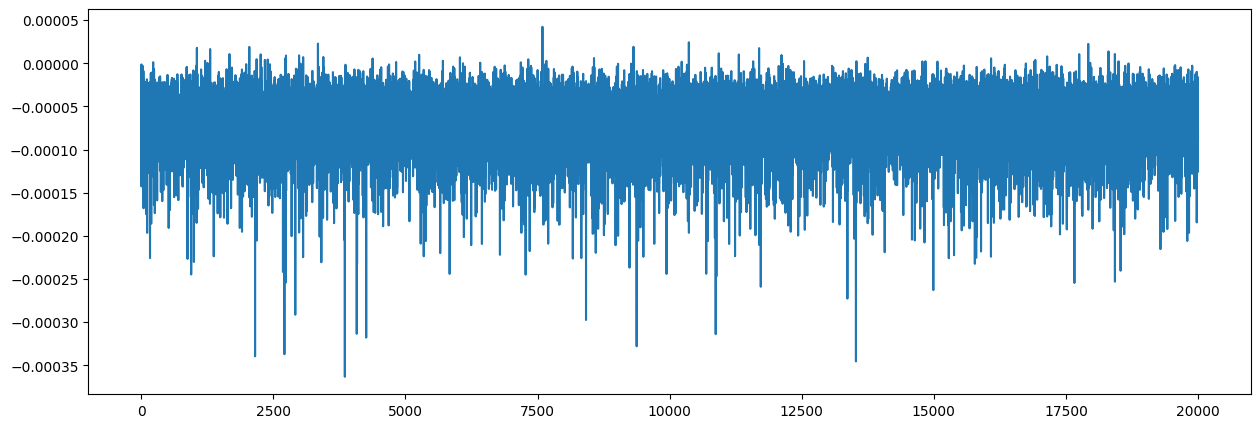

In [12]:
trained_model_state = train_model(model_state, dataloader, num_epochs=10000)

In [13]:
from flax.training import checkpoints

In [14]:
checkpoints.save_checkpoint(
    ckpt_dir='my_checkpoints/',
    target=trained_model_state,
    step=100,
    prefix='my_model',
    overwrite=True,
)

'my_checkpoints\\my_model100'

In [15]:
loaded_model_state = checkpoints.restore_checkpoint(
    ckpt_dir='my_checkpoints/',
    target=model_state,
    prefix='my_model',
)

In [16]:
trained_model = model.bind(trained_model_state.params)